## Warp 2p ROIs using transf matrix

In [5]:
import os
import cv2

import numpy as np
import pylab as pl
import tifffile as tf
import cPickle as pkl

from pipeline.python.coregistration.align_fov import Animal, FOV, warp_im, transform_2p_fov
#  orient_2p_to_macro, scale_2p_fov,
from pipeline.python.rois import utils as roi_utils
from pipeline.python import utils as putils

import numpy.ma as ma
import matplotlib.gridspec as gridspec


In [6]:
%matplotlib notebook

In [7]:


# def plot_roi_overlay(roi_img, roi_zproj, ax=None, cmap='jet', vmin=None, vmax=None):
#     '''Combine one image with another as overlay
#     '''
    
#     if vmin is None or vmax is None:
#         vmin, vmax = (roi_img.min(), roi_img.max())
        
#     roi_img_overlay = np.ma.masked_where(roi_img == 0, roi_img)
    
#     if ax is None:
#         fig, ax = pl.subplots()
        
#     ax.imshow(roi_zproj, cmap='gray')
#     ax.imshow(roi_img_overlay, cmap=cmap, vmin=vmin, vmax=vmax)
#     ax.axis('off')
    
#     return 



## Set output dir

In [8]:
#outdir = os.path.join(aggregate_dir, 'quality-checks', 'area-assignment')
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
outdir = os.path.join(aggregate_dir, 'data-stats', 'area-assignment', 'retinotopic-mapper')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/area-assignment/retinotopic-mapper


## Load coregistration results (2p fovs aligned to widefield)

In [9]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC113'
session = '20191018'


# Load coregistration results for animal
# --------------------------------------------------
coreg_dfile = os.path.join(rootdir, animalid, 'coreg', 'FOVs.pkl')
with open(coreg_dfile, 'rb') as f:
    A = pkl.load(f)
     
vasculature = A.reference.copy()  # surface img for WF retino map (+ 2p fov alignment)
print("Found %i fovs." % len(A.session_list.keys()))


# Get specificied 2p FOV (unaligned + aligned)
# --------------------------------------------------
for f in A.session_list.keys():
    print(f)
fov_key = [f for f in A.session_list.keys() if session in f][0]
fov_name = fov_key.split('%s_' % session)[-1]
fov_ = A.session_list[fov_key]


coreg_fov2p_transformed = fov_.image.copy() # transformed + pixel-scaled image (pre-alignment)
coreg_fov2p_warped = fov_.alignment['aligned'] # aligned 2p fov 


Found 5 fovs.
20191017_FOV1_zoom2p0x
20191012_FOV3_zoom2p0x
20191018_FOV1_zoom2p0x
20191012_FOV2_zoom2p0x
20191012_FOV1_zoom2p0x


<IPython.core.display.Javascript object>


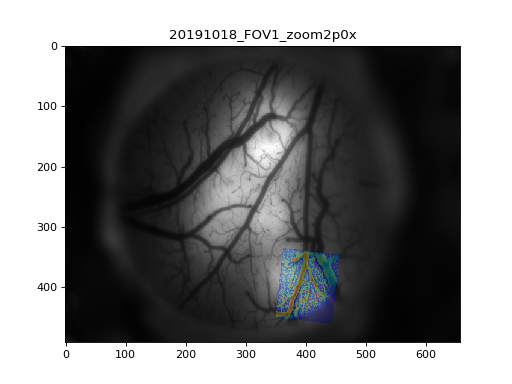

In [10]:

pl.figure()
fov2p_aligned_overlay = np.ma.masked_where(coreg_fov2p_warped == 0, coreg_fov2p_warped)
pl.imshow(vasculature, cmap='gray')
pl.imshow( fov2p_aligned_overlay, cmap='jet', alpha=0.3)

pl.title(fov_key)

pl.savefig(os.path.join(outdir, '%s_%s_%s_coregistration.png' % (session, animalid, fov_name)))


In [19]:
dir(fov_)

['__doc__',
 '__init__',
 '__module__',
 'acquisition',
 'alignment',
 'animalid',
 'coreg_dir',
 'get_transformed_image',
 'image',
 'image_fpath',
 'image_path',
 'meta',
 'pixel_size',
 'rootdir',
 'scale_anatomicals',
 'session',
 'transform_anatomicals']

# Load ROI masks and 2p images

In [12]:
#### Get roi masks 
traceid= 'traces001'
roi_id = None

if roi_id is None:
    roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov_name, traceid=traceid)
roi_masks, roi_zproj = roi_utils.load_roi_masks(animalid, session, fov_name, rois=roi_id)
print("Loaded rois: %s" % roi_id)
print(roi_masks.shape)

data_id = '%s_%s_%s_%s_%s' % (fov_.session, fov_.animalid, fov_name, roi_id, traceid)
print(data_id)


Loaded rois: rois001
(512, 512, 210)
20191018_JC113_FOV1_zoom2p0x_rois001_traces001


# Transform + warp images

In [15]:
reload(putils)

<module 'pipeline.python.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/utils.py'>

In [16]:
#### Adjust zimg contrast
roi_zproj_eq = putils.adjust_image_contrast(roi_zproj, clip_limit=10.0, tile_size=5)

#### Transform 2p fov zproj image to match widefield orientation
transf_zproj = transform_2p_fov(roi_zproj_eq, fov_.pixel_size)

#### Apply coreg warp to zproj image to aligne with WF BVs
transform_mat = fov_.alignment['transform_matrix'].copy()
warped_zproj = warp_im(transf_zproj.astype(float), transform_mat, vasculature.shape)

#### Also apply warp to EACH roi mask image
d1, d2, nrois = roi_masks.shape  
transf_rois = np.dstack([transform_2p_fov(roi_masks[:, :, i].astype(float), fov_.pixel_size) \
               for i in np.arange(0, nrois)]) # transform/orient
warped_rois = np.dstack([warp_im(transf_rois[:, :, i], transform_mat, vasculature.shape) \
               for i in np.arange(0, nrois)]) # warp
    

## Create overlay arrays for plotting

In [17]:
# def assign_int_to_masks(roi_masks):
#     d1, d2, nrois = roi_masks.shape

#     int_rois = np.dstack([roi_masks[:, :, r].astype(bool).astype(int)*(r+1) for r in np.arange(0, nrois)])
    
#     int_rois_sum = np.zeros((d1, d2))
#     for ri in np.arange(0, nrois):
#         curr_msk = int_rois[:, :, ri].copy()
#         int_rois_sum[curr_msk>0] = ri+1
        
#     #int_rois_sum = int_rois.sum(axis=-1)
#     int_roi_overlay = int_rois_sum.copy().astype(float)
#     int_roi_overlay[int_rois_sum==0] = np.nan
#     #np.ma.masked_array(int_rois_sum==0, int_rois_sum)
#     print(nrois, int_rois_sum.min(), int_rois_sum.max())
    
#     return int_roi_overlay

In [18]:
# assign unique roi id to original roi masks
rois_orig_overlay = roi_utils.assign_int_to_masks(roi_masks.astype(bool).astype(int))

# assign unique roi id to mask for transformed 2p fov
rois_transf_overlay = roi_utils.assign_int_to_masks(transf_rois.astype(bool).astype(int))

# assign unique roi id to WF-warped roi image
rois_warped_overlay = roi_utils.assign_int_to_masks(warped_rois.astype(bool).astype(int))


(210, 0.0, 210.0)
(210, 0.0, 210.0)
(210, 0.0, 210.0)


## Plot all the steps

<IPython.core.display.Javascript object>


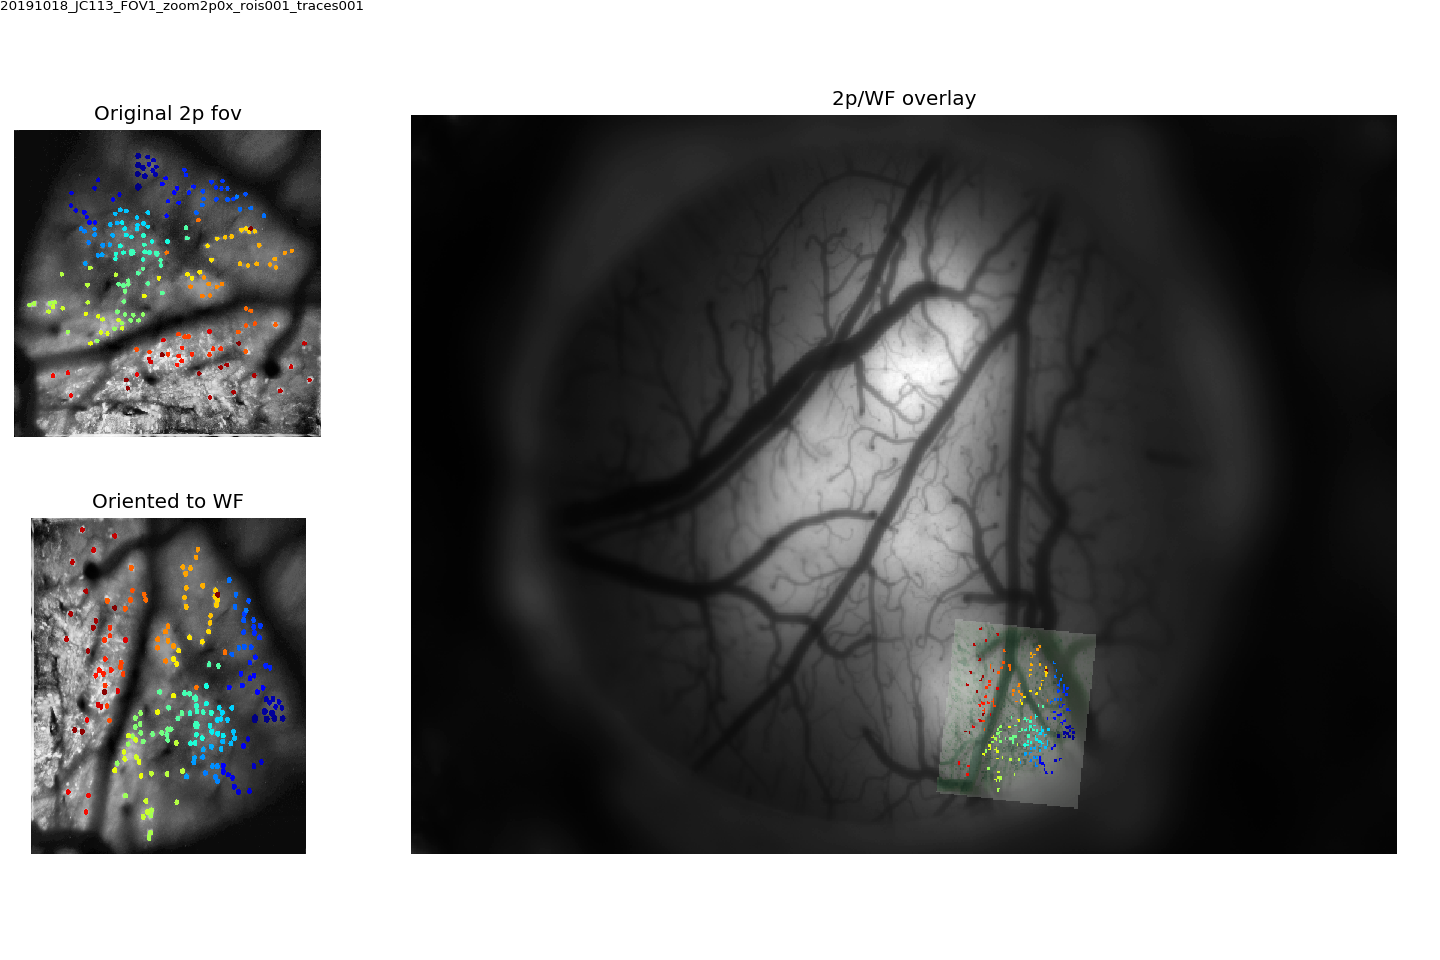

('/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/area-assignment/retinotopic-mapper', u'20191018_JC113_FOV1_zoom2p0x_rois001_traces001')


In [20]:
#fig = pl.figure(figsize=(10,20), dpi=150) #constrained_layout=True)
fig = pl.figure(figsize=(12, 8), dpi=150)
gs = gridspec.GridSpec(ncols=4, nrows=2) #, figure=fig)

ax = fig.add_subplot(gs[0, 0])
roi_utils.plot_roi_overlay(rois_orig_overlay, roi_zproj_eq, ax=ax,vmin=0, vmax=nrois)
ax.set_title('Original 2p fov')

ax = fig.add_subplot(gs[1, 0])
roi_utils.plot_roi_overlay(rois_transf_overlay, transf_zproj, ax=ax, vmin=0, vmax=nrois)
ax.set_title('Oriented to WF')


ax = fig.add_subplot(gs[0:, 1:])
ax.imshow(vasculature, cmap='gray')
ax.imshow( fov2p_aligned_overlay, cmap='Greens', alpha=0.2)
ax.imshow( rois_warped_overlay, cmap='jet', alpha=1.0,  vmin=0, vmax=nrois)
ax.axis('off')
ax.set_title('2p/WF overlay')

putils.label_figure(fig, data_id)
pl.subplots_adjust(left=0.01, right=0.99, hspace=0.2)
pl.savefig(os.path.join(outdir, '%s.png' % data_id))
print(outdir, data_id)

In [21]:
dir(fov_)

['__doc__',
 '__init__',
 '__module__',
 'acquisition',
 'alignment',
 'animalid',
 'coreg_dir',
 'get_transformed_image',
 'image',
 'image_fpath',
 'image_path',
 'meta',
 'pixel_size',
 'rootdir',
 'scale_anatomicals',
 'session',
 'transform_anatomicals']

In [22]:

#### Save
coreg_dir = os.path.split(coreg_dfile)[0]
alignment_outfile = os.path.join(coreg_dir, 'alignment_results.pkl')

'''
Saves:
    fov2p_transformed : 2p fov rotated, flipped, and pixel-scaled.
    fov2p_warped : 2p fov warped to align to widefield vasculature image with warp_mat.
    warp_mat : Transformation matrix to align 2p to widefield (wrap_im()).
    vasculature : Surface image (common to retino + 2p fov coreg.)
    
    
'''

class struct():
    pass
coreg_d = {'BV_transformed': coreg_fov2p_transformed,
           'BV_warped': coreg_fov2p_warped,
           'warp_mat': transform_mat,
           'vasculature': vasculature,
           'pixel_size': fov_.pixel_size}


# coreg_d = struct()
# coreg_d.transformed = coreg_fov2p_transformed
# coreg_d.warped = coreg_fov2p_warped

zproj_d = struct() #
zproj_d.original = roi_zproj
zproj_d.transformed = transf_zproj
zproj_d.warped = warped_zproj

rois_d = struct()
rois_d.original = roi_masks
rois_d.transformed = transf_rois
rois_d.warped = warped_rois


D = {'coreg': coreg_d,
    'zproj': zproj_d,
    'rois': rois_d}

with open(alignment_outfile, 'wb') as f:
    pkl.dump(D, f, protocol=pkl.HIGHEST_PROTOCOL)
    
    
# # outf = h5py.File(alignment_outfile, 'a')
# try:
#     #if fkey in outf.keys():
#     f = outf[fkey] if fkey in outf.keys() else outf.create_group(fkey)
#     #f = outf.create_group(fkey)

#     grp = f.create_dataset('coreg/fov2p_transformed', coreg_fov2p_transformed.shape, dtype=coreg_fov2p_transformed.dtype)
#     grp[...] = coreg_fov2p_transformed
#     grp = f.create_dataset('coreg/fov2p_warped', coreg_fov2p_warped.shape, dtype=coreg_fov2p_warped.dtype)
#     grp[...] = coreg_fov2p_warped
#     grp = f.create_dataset('coreg/warp_mat', transform_mat.shape, dtype=transform_mat.dtype)
#     grp[...] = transform_mat
#     grp = f.create_dataset('coreg/vasculature', vasculature.shape, dtype=vasculature.dtype)
#     grp[...] = vasculature
#     grp.attrs['fov2p_transformed'] = '2p fov rotated, flipped, and pixel-scaled'
#     grp.attrs['fov2p_warped'] = '2p fov warped to align to widefield vasculature image with warp_mat'
#     grp.attrs['warp_mat'] = 'Transformation matrix to align 2p to widefield (wrap_im())'
#     grp.attrs['source'] = coreg_dfile
#     grp.attrs['pixel_size'] = fov_.pixel_size


#     grp = f.create_dataset('zproj/image', roi_zproj.shape, dtype=roi_zproj.dtype)
#     grp[...] = roi_zproj
#     grp = f.create_dataset('zproj/transformed', roi_zproj_transf.shape, dtype=roi_zproj_transf.dtype)
#     grp[...] = roi_zproj_transf
#     grp = f.create_dataset('zproj/warped', roi_zproj_warped.shape, dtype=roi_zproj_warped.dtype)
#     grp[...] = roi_zproj_warped


#     grp = f.create_dataset('rois/masks', roi_masks.shape, dtype=roi_masks.dtype)
#     grp[...] = roi_masks
#     grp = f.create_dataset('rois/transformed', transf_rois.shape, dtype=transf_rois.dtype)
#     grp[...] = transf_rois
#     grp = f.create_dataset('rois/warped', warped_rois.shape, dtype=warped_rois.dtype)
#     grp[...] = warped_rois

#     grp.attrs['roiid'] = roi_id
#     grp.attrs['traceid'] = traceid
# except Exception as e:
#     traceback.print_exc()
# finally:
#     outf.close()


# np.savez(alignment_outfile, 
#          'coreg_transformed': fov2p_transformed,
#          'coreg_aligned': fov2p_to_widefield,
         
#          'roi_zproj': roi_zproj,
#          'roi_summed': roi_img,
#          'roi_masks': roi_masks,
         
#          'transform_mat': transform_mat,
         
#          )

In [23]:
print(alignment_outfile)

/n/coxfs01/2p-data/JC113/coreg/alignment_results.pkl


#### Load area boundaries

In [222]:

borders_dfile = glob.glob(os.path.join(aggregate_dir, 'widefield-maps', 'signmaps',
                      'retinotopic-mapper', '%s_*' % animalid, '*%s_results.pkl' % animalid))[0]
with open(borders_dfile, 'rb') as f:
    retino = pkl.load(f)

ImportError: No module named retinotopic_mapping.RetinotopicMapping

In [89]:
# load anatomical (transformed)

def load_anatomical(animalid, session, fov, fmt='tif', channel_id=2, rootdir='/n/coxfs01/2p-data'):

    anat_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'anatomical', \
                                        'anatomical_Channel%02d*scaled.%s' % (channel_id, fmt)))[0]
    
    if fmt=='tif':
        img = tf.imread(anat_fpath)
    else:
        img = cv2.imread(anat_fpath)
        
    if len(img.shape)>2:
        img = img[:, :, 0]
    
    return img

<IPython.core.display.Javascript object>


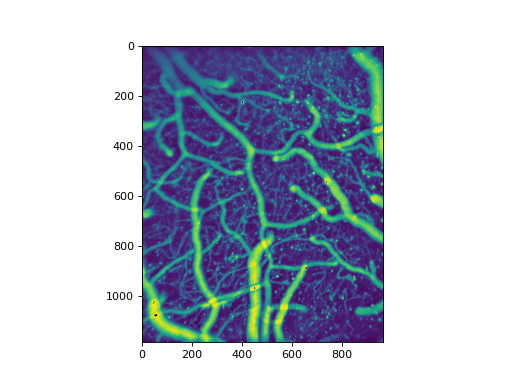

In [91]:
zimg = load_anatomical(animalid, session, fov, fmt=fmt)
pl.figure()
pl.imshow(zimg)

In [74]:
xaxis_conversion = 2.31 #2.312 # goes with A-P axis
yaxis_conversion = 1.89  #1.904 # goes with M-L axis

d1, d2 = img.shape # (im_h, im_w)
new_d1 = int(round(d1*xaxis_conversion, 1)) # after transform, 
new_d2 = int(round(d2*yaxis_conversion, 1)) # after transform, d2~ML axis (width), 
zimg_r = cv2.resize(im, (new_d2, new_d1))   # (new_d1~COLS, new_d2~ROWS)
print(zimg_r.shape)
print(new_d1, new_d2)

In [83]:
img.size

262144

<IPython.core.display.Javascript object>


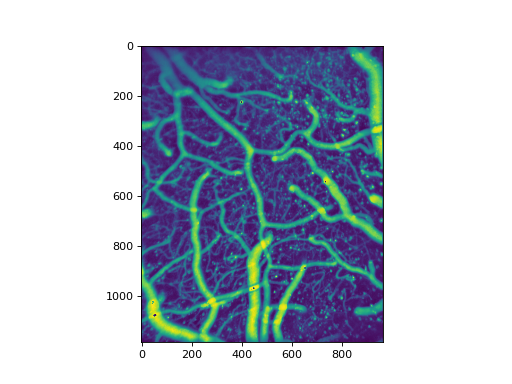

In [84]:
pl.figure()
pl.imshow(zimg_r)

In [60]:
img_outpath = '%s_scaled2.%s' % (os.path.splitext(anat_fpath)[0], fmt)

if fmt=='tif':
    tf.imsave(img_outpath, zimg_r)
else:
    cv2.imwrite(img_outpath, zimg_r)



True

In [ ]:
('saved results: ', '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC076_20190404/20190404_MJC076_results.pkl')